# 0 - PROJETO imobiliária

Precificação de imoveis residenciais com modelos preditivos, este projeto tem como objetivo utilizar uma base de estudo de imoveis e valores fictícios como treinamente e teste, assim então treinar três modelos de ML e validar o desempenho de ambos os modelo.

* Observação, os outputs destacados em vermelho são mensagens do spark de alarme ou processamento e não um erro.  

# 1 - INSTANCIANDO O SPARK e LIBs

In [1]:
# Criar uma variavel de ambiente apontando para a instalacao do spark e java

import os 

os.environ["SPARK_HOME"] = "/home/leonardojdss/spark/spark-3.5.1-bin-hadoop3"
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql import functions as f
spark = SparkSession.builder.master('local[*]').getOrCreate()
spark

your 131072x1 screen size is bogus. expect trouble
24/08/21 21:30:28 WARN Utils: Your hostname, DESKTOP-SGB43IG resolves to a loopback address: 127.0.1.1; using 172.24.73.240 instead (on interface eth0)
24/08/21 21:30:28 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/21 21:30:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# 2 - Manipulação dos dados & Exploração

### 2.1 Carga de dado

In [3]:
# Leitura do arquivo Json Imoveis

# Leitura da fonte de dados
path_imoveis = "/home/leonardojdss/Documentos/trilha_spark_apache_python/02_Spark_ML_regressao/Fonte_Dados/imoveis.json"
dados_imoveis_original = spark.read.json(path_imoveis)

In [4]:
# Analisando o que se tornou o objeto dados

dados_imoveis_original

DataFrame[ident: struct<customerID:string,source:string>, listing: struct<address:struct<city:string,location:struct<lat:double,lon:double>,neighborhood:string,zone:string>,features:struct<bathrooms:bigint,bedrooms:bigint,floors:bigint,parkingSpaces:bigint,suites:bigint,totalAreas:string,unitFloor:bigint,unitsOnTheFloor:bigint,usableAreas:string>,prices:struct<price:string,tax:struct<condo:string,iptu:string>>,types:struct<unit:string,usage:string>>]

In [5]:
# Analisando os dados de imoveis

dados_imoveis_original.show(truncate=False)

# Observe que por ser um json a forma que o spark configura o arquivo é colocando em colunas, estão em colunas nomeadas como ident e listing 
# porque é o cojunto mais superior da identação do json

+--------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ident                     |listing                                                                                                                                                          |
+--------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|{775564-BOJSMVON, Website}|{{Rio de Janeiro, {-22.909429, -43.413557}, Taquara, Zona Oeste}, {0, 0, 0, 1, 0, 62, 0, 0, 62}, {45000, {150, 0}}, {Outros, Residencial}}                       |
|{660895-AUENKNYY, Website}|{{Rio de Janeiro, {-22.869698, -43.509141}, Santíssimo, Zona Oeste}, {1, 2, 0, 1, 0, 0, 0, 0, 44}, {45000, {120, 0}}, {Apartamento, Residencial}}                |
|{751522-JESYFEQL, Website}|{{Rio de Janeiro,

In [6]:
# Contar a quantidade de dados que iremos trabalhar

print("Iremos trabalhar com:",dados_imoveis_original.count(), "Linhas")

Iremos trabalhar com: 73615 Linhas


### 2.2 Seleção de features

* O objetivo será analisar o DataSet e extrair quais colunas (features) devem permanecer para que eu possar construir um modelo de regressão que seja eficiente com os meus dados, um ponto que precisa ficar claro nessa etapa de seleção é justamento a seleção da colunas que realmente fazem sentido serem estudadas pelo modelo, porque não necessariamente mais colunas significa que meu modelo vai ser melhor, existem colunas que na verdade podem até criar viés, por isso é importante selecionar as coluna que fazem sentido para as regras de negócios.

In [7]:
# Analisando o schema do json

dados_imoveis_original.printSchema()

root
 |-- ident: struct (nullable = true)
 |    |-- customerID: string (nullable = true)
 |    |-- source: string (nullable = true)
 |-- listing: struct (nullable = true)
 |    |-- address: struct (nullable = true)
 |    |    |-- city: string (nullable = true)
 |    |    |-- location: struct (nullable = true)
 |    |    |    |-- lat: double (nullable = true)
 |    |    |    |-- lon: double (nullable = true)
 |    |    |-- neighborhood: string (nullable = true)
 |    |    |-- zone: string (nullable = true)
 |    |-- features: struct (nullable = true)
 |    |    |-- bathrooms: long (nullable = true)
 |    |    |-- bedrooms: long (nullable = true)
 |    |    |-- floors: long (nullable = true)
 |    |    |-- parkingSpaces: long (nullable = true)
 |    |    |-- suites: long (nullable = true)
 |    |    |-- totalAreas: string (nullable = true)
 |    |    |-- unitFloor: long (nullable = true)
 |    |    |-- unitsOnTheFloor: long (nullable = true)
 |    |    |-- usableAreas: string (nullable =

In [8]:
# Analisando os dados com uma perspectiva colunar 

dados_imoveis_original.\
    select('ident.customerID','listing.*')\
    .show(truncate=False)


+---------------+--------------------------------------------------------------------------------+-------------------------------+---------------------+--------------------------+
|customerID     |address                                                                         |features                       |prices               |types                     |
+---------------+--------------------------------------------------------------------------------+-------------------------------+---------------------+--------------------------+
|775564-BOJSMVON|{Rio de Janeiro, {-22.909429, -43.413557}, Taquara, Zona Oeste}                 |{0, 0, 0, 1, 0, 62, 0, 0, 62}  |{45000, {150, 0}}    |{Outros, Residencial}     |
|660895-AUENKNYY|{Rio de Janeiro, {-22.869698, -43.509141}, Santíssimo, Zona Oeste}              |{1, 2, 0, 1, 0, 0, 0, 0, 44}   |{45000, {120, 0}}    |{Apartamento, Residencial}|
|751522-JESYFEQL|{Rio de Janeiro, {-22.986927, -43.646786}, Pedra de Guaratiba, Zona Oeste}      |{0

In [9]:
# Analisando os dados com uma perspectiva colunar, avaliando algumas identações inferiores

dados_imoveis_original\
    .select('ident.customerID', 'listing.types.*', 'listing.features.*', 'listing.address.*', 'listing.prices.price', 'listing.prices.tax.*')\
    .show(truncate=False)

+---------------+-----------+-----------+---------+--------+------+-------------+------+----------+---------+---------------+-----------+--------------+------------------------+------------------------+------------+-----+-----+----+
|customerID     |unit       |usage      |bathrooms|bedrooms|floors|parkingSpaces|suites|totalAreas|unitFloor|unitsOnTheFloor|usableAreas|city          |location                |neighborhood            |zone        |price|condo|iptu|
+---------------+-----------+-----------+---------+--------+------+-------------+------+----------+---------+---------------+-----------+--------------+------------------------+------------------------+------------+-----+-----+----+
|775564-BOJSMVON|Outros     |Residencial|0        |0       |0     |1            |0     |62        |0        |0              |62         |Rio de Janeiro|{-22.909429, -43.413557}|Taquara                 |Zona Oeste  |45000|150  |0   |
|660895-AUENKNYY|Apartamento|Residencial|1        |2       |0     |1

In [10]:
# Analisando os dados com uma perspectiva colunar, removendo algumas colunas que não fazem muito sentido serem estudadas

# Colunas selecionadas estão no select e as colunas removidas estão no drop

dados_imoveis_original\
    .select('ident.customerID', 'listing.types.*', 'listing.features.*', 'listing.address.*', 'listing.prices.price', 'listing.prices.tax.*')\
    .drop('city', 'location', 'totalAreas')\
    .show(truncate=False)

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+------------------------+------------+-----+-----+----+
|customerID     |unit       |usage      |bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|neighborhood            |zone        |price|condo|iptu|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+------------------------+------------+-----+-----+----+
|775564-BOJSMVON|Outros     |Residencial|0        |0       |0     |1            |0     |0        |0              |62         |Taquara                 |Zona Oeste  |45000|150  |0   |
|660895-AUENKNYY|Apartamento|Residencial|1        |2       |0     |1            |0     |0        |0              |44         |Santíssimo              |Zona Oeste  |45000|120  |0   |
|751522-JESYFEQL|Outros     |Residencial|0        |0       |0     |0            |0     |0 

In [11]:
# Features selecionadas, agora devemos aplicar essa seleção ao dataset

dataset_imoveis = dados_imoveis_original\
    .select('ident.customerID', 'listing.types.*', 'listing.features.*', 'listing.address.*', 'listing.prices.price', 'listing.prices.tax.*')\
    .drop('city', 'location', 'totalAreas')


### 2.3 Tratamento do DataSet

In [12]:
# Analisando os tipos de cada coluna, essa análise é importante para aferir se tipagem realmente está correta

dataset_imoveis.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- unit: string (nullable = true)
 |-- usage: string (nullable = true)
 |-- bathrooms: long (nullable = true)
 |-- bedrooms: long (nullable = true)
 |-- floors: long (nullable = true)
 |-- parkingSpaces: long (nullable = true)
 |-- suites: long (nullable = true)
 |-- unitFloor: long (nullable = true)
 |-- unitsOnTheFloor: long (nullable = true)
 |-- usableAreas: string (nullable = true)
 |-- neighborhood: string (nullable = true)
 |-- zone: string (nullable = true)
 |-- price: string (nullable = true)
 |-- condo: string (nullable = true)
 |-- iptu: string (nullable = true)



* Após essa validação, podemos concluir que usableAreas, price, condo e iptu não deveria ser uma string, e sim double e integer

In [13]:
# Alterando os tipos de usableAreas, price, condo e iptu

# usableAreas > Tipo IntegerType
# price > Tipo DoubleType
# condo > Tipo DoubleType
# iptu > Tipo IntegerType

dataset_imoveis = dataset_imoveis\
    .withColumn('usableAreas', dataset_imoveis.usableAreas.cast(IntegerType()))\
    .withColumn('price', dataset_imoveis.price.cast(DoubleType()))\
    .withColumn('condo', dataset_imoveis.condo.cast(DoubleType()))\
    .withColumn('iptu', dataset_imoveis.iptu.cast(IntegerType()))

In [14]:
# Analisando o DataSet após alteração

dataset_imoveis.show()

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+----+
|     customerID|       unit|      usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|        neighborhood|        zone|  price|condo|iptu|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+----+
|775564-BOJSMVON|     Outros|Residencial|        0|       0|     0|            1|     0|        0|              0|         62|             Taquara|  Zona Oeste|45000.0|150.0|   0|
|660895-AUENKNYY|Apartamento|Residencial|        1|       2|     0|            1|     0|        0|              0|         44|          Santíssimo|  Zona Oeste|45000.0|120.0|   0|
|751522-JESYFEQL|     Outros|Residencial|        0|       0|     0|            0|     0|        0|  

In [15]:
# Analisando os DataSet para entender como está a distribuição dos tipos de agrupamentos que pode existir na coluna usage

dataset_imoveis\
    .select("usage")\
    .groupBy("usage")\
    .count()\
    .show()

+-----------+-----+
|      usage|count|
+-----------+-----+
|  Comercial| 4019|
|Residencial|69596|
+-----------+-----+



* Será necessario remover do DataSet todos os dados que pertence ao grupo de imoveis comerciais, nosso objetivo é prever o preços de imoveis residenciais. 

In [16]:
# Removendo os dados que pertence ao grupo de imoveis comerciais

dataset_imoveis = dataset_imoveis\
    .select("*")\
    .where('usage=="Residencial"')

In [17]:
# Analisando os DataSet para entender como está a distribuição dos tipos de agrupamentos que pode existir na coluna unit

dataset_imoveis\
    .select("unit")\
    .groupBy("unit")\
    .count()\
    .show()

+-----------+-----+
|       unit|count|
+-----------+-----+
|     Outros| 1190|
|Apartamento|59106|
|       Casa| 9300|
+-----------+-----+



In [18]:
# Analisando os DataSet para entender como está a distribuição dos tipos de agrupamentos que pode existir na coluna zone

dataset_imoveis\
    .select("zone")\
    .groupBy("zone")\
    .count()\
    .show()

+------------+-----+
|        zone|count|
+------------+-----+
|  Zona Norte|14379|
|  Zona Oeste|35523|
|Zona Central| 1002|
|    Zona Sul|18535|
|            |  157|
+------------+-----+



In [19]:
# Analisando as colunas que possuem dados faltantes, contagem de nulos ou nan por colunas

dataset_imoveis\
    .select([f.count(f.when(f.isnull(c) | f.isnan(c), True)).alias(c) for c in dataset_imoveis.columns])\
    .show()

+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+
|customerID|unit|usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|neighborhood|zone|price|condo|iptu|
+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+
|         0|   0|    0|        0|       0|     0|            0|     0|        0|              0|          0|           0|   0|    0| 6061|8726|
+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+



* Como observado no resultado da contagem, existem muitos valores nulos ou NaN nas colunas condo e iptu, remover esses dados não é um caminho porque são muitas repetições, o melhor caminho será atribuir um valor nessas colunas, no spark é possivel inserir o valor 0 nas null

In [20]:
#Substituindo os valores de nulos em socios

# Método para inteiros (integer)
dataset_imoveis = dataset_imoveis.na.fill(0)

# fill(0) = 0, então o valor substituido do nulo será 0 em todos os campos

In [21]:
# Analisando as colunas que possuem dados faltantes, dados faltando que não são nulo

dataset_imoveis\
    .select("zone")\
    .groupBy("zone")\
    .count()\
    .show()

+------------+-----+
|        zone|count|
+------------+-----+
|  Zona Norte|14379|
|  Zona Oeste|35523|
|Zona Central| 1002|
|    Zona Sul|18535|
|            |  157|
+------------+-----+



* Podemos analisar que na coluna zone, existem 157 observações (linhas) vazias, são strings vazias, o melhor caminho será remover do meu dataset essas observações (linhas), podemos fazer essa ação devido a quantidade ser pequena.

In [22]:
# Removendo as 157 linhas que contem o campo zone vazio

dataset_imoveis = dataset_imoveis\
    .select("*")\
    .where('zone!=""')

# ou
# dataset_imoveis = dataset_imoveis\
#    .where(f.col('zone') != '')


# 3 - Modelos de Machine Learning

### 3.1 Modelo Regressão Linear
### 3.1.1 Preparando os dados

Para trabalhar com regressão linear, não podemos passar os dados da forma como eles são gerados, no sentido de que ao passar strings o modelo não trabalha muito bem, a solução desse problema é transformar os dados em variaveis dummy.

Variáveis dummy representam categorias categóricas em um formato binário, facilitando a análise de dados, exemplo:

Na coluna zone do nosso dataset possui quatro grupos sendo eles Zona Norte, Zona Oeste, Zona Central e Zona Sul, ao realizar os processo de dummy zona norte se transform em 0, Zona Oeste em 1, Zona Central em 3....... Desta forma o modelo consegue trabalhar com mais facilidade, por que ele entende os numeros e as combinações desses numeros nas varias colunas do dataset.

In [23]:

dataset_imoveis.limit(5).show(truncate=False)

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+------------------------+----------+-------+-----+----+
|customerID     |unit       |usage      |bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|neighborhood            |zone      |price  |condo|iptu|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+------------------------+----------+-------+-----+----+
|775564-BOJSMVON|Outros     |Residencial|0        |0       |0     |1            |0     |0        |0              |62         |Taquara                 |Zona Oeste|45000.0|150.0|0   |
|660895-AUENKNYY|Apartamento|Residencial|1        |2       |0     |1            |0     |0        |0              |44         |Santíssimo              |Zona Oeste|45000.0|120.0|0   |
|751522-JESYFEQL|Outros     |Residencial|0        |0       |0     |0            |0     |0 

In [24]:
# Criando as variaves para os textos da coluna unit

unit = dataset_imoveis\
    .groupBy("customerID")\
    .pivot('unit')\
    .agg(f.lit(1))\
    .na\
    .fill(0)

In [25]:
# Criando as variaves para os textos da coluna zone

zone = dataset_imoveis\
    .groupBy("customerID")\
    .pivot('zone')\
    .agg(f.lit(1))\
    .na\
    .fill(0)

In [26]:
# unindo as informações de unit e zone ao dataset

dataset_imoveis = dataset_imoveis\
    .join(unit, 'customerID', how='inner')\
    .join(zone, 'customerID', how='inner')

In [27]:
# Analisando os dados após a junção

dataset_imoveis.show()

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+----+-----------+----+------+------------+----------+----------+--------+
|     customerID|       unit|      usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|        neighborhood|        zone|  price|condo|iptu|Apartamento|Casa|Outros|Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+----+-----------+----+------+------------+----------+----------+--------+
|775564-BOJSMVON|     Outros|Residencial|        0|       0|     0|            1|     0|        0|              0|         62|             Taquara|  Zona Oeste|45000.0|150.0|   0|          0|   0|     1|           0|         0|         1|       0|
|660895-

In [28]:
# A variavel target no Spark deve ser chamada de label, então deve ser renomeada a coluna price para labe

dataset_imoveis = dataset_imoveis.withColumnRenamed('price', 'label')

In [29]:
# Separação as features X

x = [
 'bathrooms',
 'bedrooms',
 'floors',
 'parkingSpaces',
 'suites',
 'unitFloor',
 'unitsOnTheFloor',
 'usableAreas',
 'condo',
 'iptu',
 'Apartamento',
 'Casa',
 'Outros',
 'Zona Central',
 'Zona Norte',
 'Zona Oeste',
 'Zona Sul'
 ]

In [30]:
# Importação da biblioteca que fará a Vetorização dos dados

from pyspark.ml.feature import VectorAssembler

# Realizando a vetorização dos meus dados

assembler = VectorAssembler(inputCols=x, outputCol= 'features')

In [31]:
# Aplicando a vetorização ao meu dataset

dataset_imoveis_transformado = assembler.transform(dataset_imoveis).select('features', 'label') 

In [32]:
dataset_imoveis_transformado.show(truncate=False)

24/08/21 21:31:02 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----------------------------------------------------------------------------+-------+
|features                                                                     |label  |
+-----------------------------------------------------------------------------+-------+
|(17,[3,7,8,12,15],[1.0,62.0,150.0,1.0,1.0])                                  |45000.0|
|(17,[0,1,3,7,8,10,15],[1.0,2.0,1.0,44.0,120.0,1.0,1.0])                      |45000.0|
|(17,[7,8,12,15],[132.0,100.0,1.0,1.0])                                       |50000.0|
|[2.0,3.0,3.0,1.0,1.0,2.0,4.0,60.0,400.0,120.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0]   |50000.0|
|(17,[7,12,15],[200.0,1.0,1.0])                                               |50000.0|
|(17,[0,1,3,7,10,14],[1.0,1.0,1.0,33.0,1.0,1.0])                              |45336.0|
|(17,[7,12,15],[120.0,1.0,1.0])                                               |45000.0|
|(17,[7,12,15],[468.0,1.0,1.0])                                               |45000.0|
|(17,[5,7,12,15],[1.0,180.0,1.0,

In [33]:
# Analisando a correlação dos dados antes de iniciar o aprendizado de máquina

# Bibliotecas
from pyspark.ml.stat import Correlation


# Calculando a correlação 
correlacao = Correlation.corr(dataset_imoveis_transformado, 'features').collect()
correlacao

24/08/21 21:31:15 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


[Row(pearson(features)=DenseMatrix(17, 17, [1.0, 0.6659, -0.0446, 0.4876, 0.7529, 0.0076, -0.1074, 0.5981, ..., 0.0088, 0.1803, -0.1833, -0.0165, -0.073, -0.3084, -0.6176, 1.0], False))]

* Observe que o resultado do cálculo da correlação não trouxe um gráfico demonstrando a correlação, para isso deve ser coletado o objeto da linha 1 [0] e coluna 1 [0]

In [34]:
# Coletando os dados para plotar a correlação de person densa
correlacao = Correlation.corr(dataset_imoveis_transformado, 'features').collect()[0][0]

# Contruindo uma lista de array para plotar a correlação
Data_Frame_array = correlacao.toArray()

# Importando pandas 
import pandas as pd

# Criando um Data Frame pandas para plotar a correlação
Data_Frame_array = pd.DataFrame(Data_Frame_array, columns=x, index=x)
Data_Frame_array

,bathrooms,bedrooms,floors,parkingSpaces,suites,unitFloor,unitsOnTheFloor,usableAreas,condo,iptu,Apartamento,Casa,Outros,Zona Central,Zona Norte,Zona Oeste,Zona Sul
bathrooms,1.000000,0.665911,-0.044591,0.487590,0.752928,0.007624,-0.107437,0.598073,0.020030,0.015102,-0.275458,0.343042,-0.140183,-0.097368,-0.162497,0.242345,-0.098752
bedrooms,0.665911,1.000000,-0.082184,0.467161,0.601199,-0.007162,-0.130814,0.563750,0.018482,0.013639,-0.258339,0.349962,-0.205608,-0.123732,-0.111712,0.163822,-0.049433
floors,-0.044591,-0.082184,1.000000,-0.048486,-0.048106,0.120982,0.737717,-0.103917,0.013797,0.006688,0.153947,-0.142090,-0.051946,0.126044,-0.016926,-0.031750,0.017402
parkingSpaces,0.487590,0.467161,-0.048486,1.000000,0.484988,0.003768,-0.074527,0.483732,0.018012,0.009721,-0.252746,0.293326,-0.072359,-0.086437,-0.109957,0.267990,-0.178807
suites,0.752928,0.601199,-0.048106,0.484988,1.000000,0.005206,-0.091914,0.577636,0.023461,0.019093,-0.236217,0.282221,-0.088834,-0.084417,-0.230317,0.327546,-0.136398
unitFloor,0.007624,-0.007162,0.120982,0.003768,0.005206,1.000000,0.092359,-0.012748,0.003065,0.001200,0.034674,-0.031403,-0.013275,0.022315,-0.011112,0.007518,-0.004333
unitsOnTheFloor,-0.107437,-0.130814,0.737717,-0.074527,-0.091914,0.092359,1.000000,-0.144222,-0.000554,0.005029,0.147497,-0.137754,-0.045523,0.153639,0.030753,-0.012434,-0.055540
usableAreas,0.598073,0.563750,-0.103917,0.483732,0.577636,-0.012748,-0.144222,1.000000,0.019717,0.014656,-0.482170,0.459136,0.125672,-0.075256,-0.158553,0.192466,-0.051962
condo,0.020030,0.018482,0.013797,0.018012,0.023461,0.003065,-0.000554,0.019717,1.000000,0.226212,0.009105,-0.008624,-0.002495,-0.003553,-0.013453,-0.001055,0.014474
iptu,0.015102,0.013639,0.006688,0.009721,0.019093,0.001200,0.005029,0.014656,0.226212,1.000000,-0.001502,0.002291,-0.001870,-0.002438,-0.008400,-0.000428,0.008835


<Axes: >

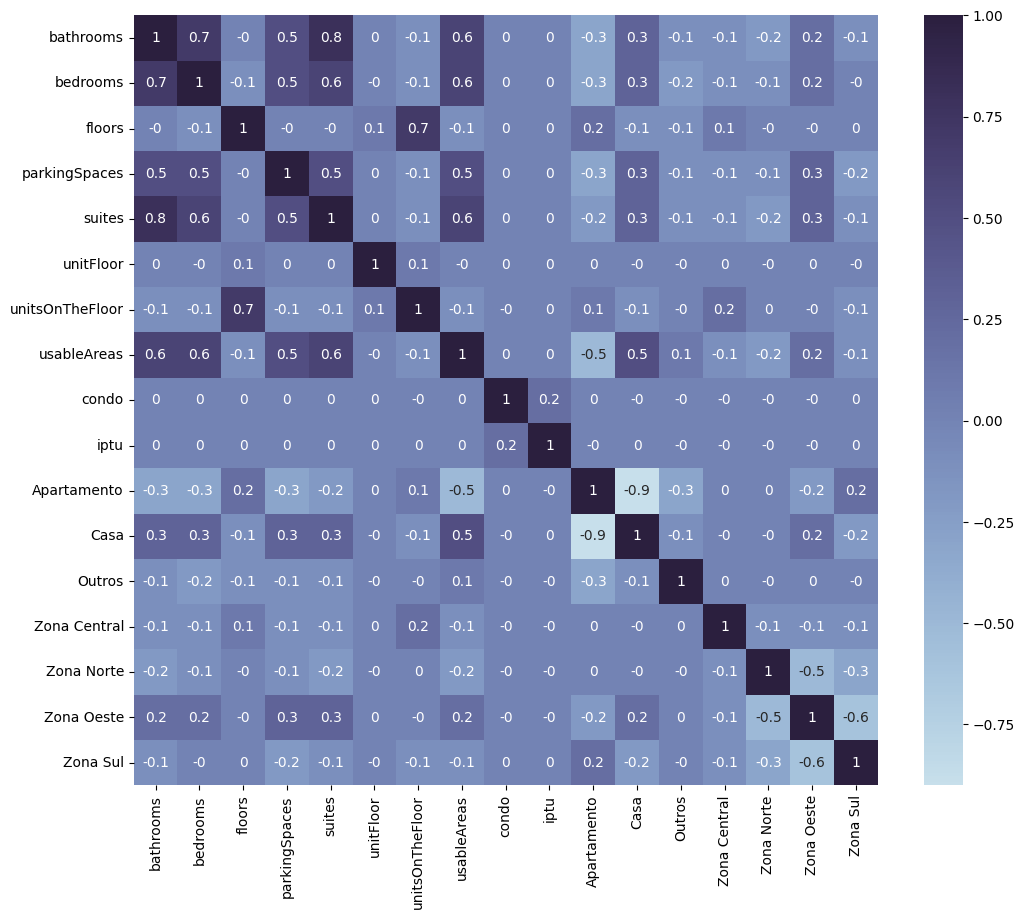

In [35]:
# Importação de Matplotlib para plotar a correlação
import matplotlib.pyplot as plt
import seaborn as sns

# Plotando 
plt.figure(figsize=(12,10))
paleta = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)
sns.heatmap(Data_Frame_array.round(1), annot=True, cmap=paleta)

### 3.1.2 Previsão

In [75]:
# importação da biblioteca para gerar a previsão
from pyspark.ml.regression import LinearRegression

# Dividindo o DataSet em teste e treino
teste, treino = dataset_imoveis_transformado.randomSplit([0.3, 0.7], seed=101)

In [76]:
# Criando um modelo de regressão linear
lr = LinearRegression()

# Realizando o treinamento com regressão
modelo_lr = lr.fit(treino)

24/08/21 21:53:26 WARN Instrumentation: [a3b44d56] regParam is zero, which might cause numerical instability and overfitting.
24/08/21 21:53:28 WARN Instrumentation: [a3b44d56] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


In [77]:
# Criando uma previsão com os dados de treino
previsoes_lr_treino = modelo_lr.transform(treino)
previsoes_lr_treino.show() 

+--------------------+--------+------------------+
|            features|   label|        prediction|
+--------------------+--------+------------------+
|(17,[0,1,2,3,4,5,...|500000.0|1141075.7508833194|
|(17,[0,1,2,3,4,5,...|308615.0| 91523.59866230481|
|(17,[0,1,2,3,4,5,...|279000.0| 103348.7868345239|
|(17,[0,1,2,3,4,5,...|199000.0|216671.55184572842|
|(17,[0,1,2,3,4,5,...|350000.0| 605431.3994218715|
|(17,[0,1,2,3,4,5,...|449000.0|396213.05468546925|
|(17,[0,1,2,3,4,5,...|420000.0| 684891.1497766905|
|(17,[0,1,2,3,4,5,...|490000.0| 830906.1428562853|
|(17,[0,1,2,3,4,5,...|379900.0| 441401.9609484724|
|(17,[0,1,2,3,4,5,...|340000.0| 510531.4604253443|
|(17,[0,1,2,3,4,5,...|430000.0|449303.42811357696|
|(17,[0,1,2,3,4,5,...|190000.0|409003.35066157184|
|(17,[0,1,2,3,4,5,...|600000.0|  799335.090521926|
|(17,[0,1,2,3,4,5,...|896000.0| 596277.5755183351|
|(17,[0,1,2,3,4,5,...|439000.0| 534708.1060561001|
|(17,[0,1,2,3,4,5,...|333000.0|337035.15630267095|
|(17,[0,1,2,3,4,5,...|948000.0|

### Podemos avaliar que foi criado a coluna prediction, visualmente é possivel validar que o modelo não teve uma performance alta, em alguns casos a distância entre Label (Custo real) e prediction (Custo previsto) é grande, esse modelo gerou pouca confiança.

### 3.1.3 Análise do modelo e Cálculo de métricas 

* Estaremos utilizando as métricas R2 e RMSE

R2 - R² (Coeficiente de Determinação), O R² mede a proporção da variabilidade nos dados de saída que é explicada pelo modelo. É uma métrica que indica o quão bem as previsões do modelo se ajustam aos dados observados.

RMSE - (Erro Quadrático Médio da Raiz), O RMSE é a raiz quadrada da média dos quadrados dos erros entre os valores previstos pelo modelo e os valores reais. Ele mede a média da magnitude dos erros de previsão.

In [78]:
# Trazendo um resumo do treino
previsoes_lr_treino =  modelo_lr.summary

# Aferindo o modelo com os dados de Teste
previsoes_lr_teste = modelo_lr.evaluate(teste)

### 3.1.4 Criando uma tabela com a performance do modelo

In [79]:
# Impressão das métricas

print('Linear Regression')
print("*"*30)
print("Dados de Treino")
print("*"*30)
print("R²: %f" % previsoes_lr_treino.r2)
print("RMSE: %f" % previsoes_lr_treino.rootMeanSquaredError)
#print("Acurácia: %f" % resumo_treino_lr.accuracy)
print("")
print("*"*30)
print("Dados de Teste")
print("*"*30)
print("R²: %f" % previsoes_lr_teste.r2)
print("RMSE: %f" % previsoes_lr_teste.rootMeanSquaredError)

Linear Regression
******************************
Dados de Treino
******************************
R²: 0.661251
RMSE: 809660.946724

******************************
Dados de Teste
******************************
R²: 0.668878
RMSE: 802037.226067


# 3.2 Modelo decision tree

### 3.2.1 Previsão

In [41]:
# Biblioteca da arvore de decisão
from pyspark.ml.regression import DecisionTreeRegressor

# Criando o modelo de arvore de decisão
dtr = DecisionTreeRegressor(seed=101, maxDepth=7)

# maxDepth = Profundidade de minha arvore ou a quantidade de decisoes
# seed = Uma numeração que faz o resultado não ser aleatorio todas as vezes que rodar o codigo

In [42]:
# Treinar modelo
modelo_dtr = dtr.fit(treino)

In [43]:
# Criando uma previsão
previsoes_dtr_treino = modelo_dtr.transform(treino)
previsoes_dtr_treino.show()

+--------------------+--------+-----------------+
|            features|   label|       prediction|
+--------------------+--------+-----------------+
|(17,[0,1,2,3,4,5,...|500000.0|552138.8790173624|
|(17,[0,1,2,3,4,5,...|308615.0|384955.1514670896|
|(17,[0,1,2,3,4,5,...|279000.0|384955.1514670896|
|(17,[0,1,2,3,4,5,...|199000.0|384955.1514670896|
|(17,[0,1,2,3,4,5,...|350000.0|856313.1838955387|
|(17,[0,1,2,3,4,5,...|449000.0|552138.8790173624|
|(17,[0,1,2,3,4,5,...|420000.0|552138.8790173624|
|(17,[0,1,2,3,4,5,...|490000.0|856313.1838955387|
|(17,[0,1,2,3,4,5,...|379900.0|384955.1514670896|
|(17,[0,1,2,3,4,5,...|340000.0|552138.8790173624|
|(17,[0,1,2,3,4,5,...|430000.0|552138.8790173624|
|(17,[0,1,2,3,4,5,...|190000.0|384955.1514670896|
|(17,[0,1,2,3,4,5,...|600000.0|552138.8790173624|
|(17,[0,1,2,3,4,5,...|896000.0|552138.8790173624|
|(17,[0,1,2,3,4,5,...|439000.0|552138.8790173624|
|(17,[0,1,2,3,4,5,...|333000.0|384955.1514670896|
|(17,[0,1,2,3,4,5,...|948000.0|743208.3542094455|


### 3.2.2 Métricas

In [44]:
# Biblioteca para métrificar meu modelo
from pyspark.ml.evaluation import RegressionEvaluator

# Realizando os cálculo de R2 e RMSE
evaluator = RegressionEvaluator()
print(evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "r2"}))
print(evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "rmse"}))
print(evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "mae"}))

0.7915828521370596


635083.755221057


348728.1456563371


In [45]:
# Gerando previsão com dados de teste
previsoes_dtr_teste = modelo_dtr.transform(teste)
previsoes_dtr_teste.show()

+--------------------+--------+------------------+
|            features|   label|        prediction|
+--------------------+--------+------------------+
|(17,[0,1,2,3,4,5,...|260000.0| 384955.1514670896|
|(17,[0,1,2,3,4,5,...|545000.0| 384955.1514670896|
|(17,[0,1,2,3,4,5,...|479000.0| 384955.1514670896|
|(17,[0,1,2,3,4,5,...|265000.0| 552138.8790173624|
|(17,[0,1,2,3,4,5,...|650000.0| 743208.3542094455|
|(17,[0,1,2,3,4,5,...|449000.0| 384955.1514670896|
|(17,[0,1,2,3,4,5,...|679000.0| 856313.1838955387|
|(17,[0,1,2,3,4,5,...|620000.0| 552138.8790173624|
|(17,[0,1,2,3,4,5,...|435000.0| 384955.1514670896|
|(17,[0,1,2,3,4,5,...|780000.0| 743208.3542094455|
|(17,[0,1,2,3,4,5,...|273944.0| 384955.1514670896|
|(17,[0,1,2,3,4,5,...|447600.0| 384955.1514670896|
|(17,[0,1,2,3,4,5,...|950000.0| 856313.1838955387|
|(17,[0,1,2,3,4,5,...|948375.0|1258351.4085850557|
|(17,[0,1,2,3,4,5,...|279000.0| 384955.1514670896|
|(17,[0,1,2,3,4,5,...|599000.0| 552138.8790173624|
|(17,[0,1,2,3,4,5,...|741000.0|

In [46]:
# Impressão das métricas

print('Decision Tree Regression')
print("*"*30)
print("Dados de Treino")
print("*"*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "rmse"}))
print("MAE: %f" % evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "mae"}))
print("")
print("*"*30)
print("Dados de Teste")
print("*"*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "rmse"}))
print("MAE: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "mae"}))

Decision Tree Regression
******************************
Dados de Treino
******************************


R²: 0.791583


RMSE: 635083.755221


MAE: 348728.145656

******************************
Dados de Teste
******************************


R²: 0.782521


RMSE: 649993.977709


MAE: 350791.348070


# 3.3 Random Forest

### 3.3.1 Previsão

In [47]:
# Biblioteca da arvore de decisão
from pyspark.ml.regression import RandomForestRegressor

# Criando o modelo de arvore de decisão
rfr = RandomForestRegressor(seed=101, maxDepth=7, numTrees=10)

# numTrees = Quantidade de arvores de decisão
# maxDepth = Profundidade de minha arvore ou a quantidade de decisoes
# seed = Uma numeração que faz o resultado não ser aleatorio todas as vezes que rodar o codigo

In [48]:
# Treinar modelo
modelo_rfr = rfr.fit(treino)

In [49]:
# Criando uma previsão
previsoes_rfr_treino = modelo_rfr.transform(treino)
previsoes_rfr_treino.show()

+--------------------+--------+------------------+
|            features|   label|        prediction|
+--------------------+--------+------------------+
|(17,[0,1,2,3,4,5,...|500000.0| 482001.2774540945|
|(17,[0,1,2,3,4,5,...|308615.0|361593.81618668174|
|(17,[0,1,2,3,4,5,...|279000.0|361593.81618668174|
|(17,[0,1,2,3,4,5,...|199000.0|361593.81618668174|
|(17,[0,1,2,3,4,5,...|350000.0| 829357.0074953727|
|(17,[0,1,2,3,4,5,...|449000.0|435697.14635560254|
|(17,[0,1,2,3,4,5,...|420000.0| 868402.1089412209|
|(17,[0,1,2,3,4,5,...|490000.0| 829357.0074953727|
|(17,[0,1,2,3,4,5,...|379900.0| 421651.2948244383|
|(17,[0,1,2,3,4,5,...|340000.0|444446.36645585066|
|(17,[0,1,2,3,4,5,...|430000.0| 499324.3329343723|
|(17,[0,1,2,3,4,5,...|190000.0|361593.81618668174|
|(17,[0,1,2,3,4,5,...|600000.0| 548366.0223437531|
|(17,[0,1,2,3,4,5,...|896000.0| 617145.5345525459|
|(17,[0,1,2,3,4,5,...|439000.0|512865.28285370686|
|(17,[0,1,2,3,4,5,...|333000.0|361593.81618668174|
|(17,[0,1,2,3,4,5,...|948000.0|

### 3.3.2 Métricas

In [50]:
# Biblioteca para métrificar meu modelo
from pyspark.ml.evaluation import RegressionEvaluator

# Realizando os cálculo de R2 e RMSE
evaluator = RegressionEvaluator()
print(evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "r2"}))
print(evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "rmse"}))
print(evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "mae"}))

0.8019566768137769


619076.5910757844


339963.81368590967


In [51]:
# Gerando previsão com dados de treino
previsoes_rfr_teste = modelo_dtr.transform(teste)

# Realizando os cálculo de R2 e RMSE
evaluator = RegressionEvaluator()
print(evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "r2"}))
print(evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "rmse"}))

0.7825209033490699


649993.9777087782


In [52]:
# Impressão das métricas
print('Random Forest Regressor')
print("*"*30)
print("Dados de Treino")
print("*"*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "rmse"}))
print("")
print("*"*30)
print("Dados de Teste")
print("*"*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "rmse"}))


Random Forest Regressor
******************************
Dados de Treino
******************************


R²: 0.801957


RMSE: 619076.591076

******************************
Dados de Teste
******************************


R²: 0.782521


RMSE: 649993.977709


# 3.4 Otimização de modelo

### 3.4.1 Técnica cross validation com Arvore de decisão

In [53]:
# importando bibliotecas para aplicar técnica
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


In [54]:
# Instanciando o modelo de arvore de decisao
dtr = DecisionTreeRegressor()

In [55]:
# Criando um grid de paramentros que precisa testar, ou seja quais configurações podem ser verificadas para encontrar uma 
# melhor solução ou parametros que faça meu modelo se ajustar melhor aos meus dados

grid = ParamGridBuilder()\
    .addGrid(dtr.maxDepth, [2, 5, 10])\
    .addGrid(dtr.maxBins, [10, 32, 45])\
    .build()

# maxDepth
# Relembrando que maxDepth é a profundidade da arvore

#------------------------------------------------------------

# maxBins
# maxBins: Número de compartimentos usados ao discretizar recursos contínuos.

# O aumento de maxBins permite que o algoritmo considere mais candidatos a divisão e tome decisões de divisão refinadas. 
# No entanto, também aumenta a computação e a comunicação.

# Observe que o parâmetro maxBins deve ter pelo menos o número máximo de categorias.

In [56]:
# Aplicando a técnica de cross validation para o modelo de arvore de decisão

evaluator = RegressionEvaluator()

dtr_cv = CrossValidator(
    estimator=dtr,
    estimatorParamMaps=grid,
    evaluator=evaluator,
    numFolds=3,
    seed=101
)

# estimator = Modelo criado
# estimatorParamMaps = os parametros que serão testados nas diferente tentativas
# evaluator = tecnica de medicao
# numFolds = quantidade de quebras dos dados de treino e teste
# seed = padronizar um resultado

In [57]:
# Treinando modelo

modelo_dtr_cv = dtr_cv.fit(treino)

In [58]:
# Gerando as previsões
previsoes_dtr_cv_teste = modelo_dtr_cv.transform(teste)

# Comparando as métricas sem cross validation e com cross validation
print('Decision Tree Regressor')
print("*"*30)
print("Sem Cross validation")
print("*"*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "rmse"}))
print("")
print("*"*30)
print("Com Cross validation")
print("*"*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_cv_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_cv_teste, {evaluator.metricName: "rmse"}))

Decision Tree Regressor
******************************
Sem Cross validation
******************************


R²: 0.782521


RMSE: 649993.977709

******************************
Com Cross validation
******************************


R²: 0.802372


RMSE: 619618.754523


### 3.4.2 Técnica cross validation com Random Forest

In [59]:
# Instanciando o modelo de Random Forest Regressor
rfr = RandomForestRegressor()

In [60]:
# Criando um grid de paramentros que preciso testar

grid = ParamGridBuilder()\
    .addGrid(rfr.numTrees, [10, 20, 30])\
    .addGrid(rfr.maxDepth, [2, 5, 10])\
    .addGrid(rfr.maxBins, [10, 32, 45])\
    .build()

In [61]:
# Aplicando a técnica de cross validation para o modelo de Random Forest Regressor

rfr_cv = CrossValidator(
    estimator=rfr,
    estimatorParamMaps=grid,
    evaluator=evaluator,
    numFolds=3,
    seed=101
)

In [62]:
# Treinando modelo

modelo_rfr_cv = rfr_cv.fit(treino)

24/08/21 21:34:51 WARN DAGScheduler: Broadcasting large task binary with size 1445.9 KiB
24/08/21 21:34:53 WARN DAGScheduler: Broadcasting large task binary with size 1491.5 KiB
24/08/21 21:34:55 WARN DAGScheduler: Broadcasting large task binary with size 1475.7 KiB
24/08/21 21:35:04 WARN DAGScheduler: Broadcasting large task binary with size 1623.1 KiB
24/08/21 21:35:05 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/08/21 21:35:08 WARN DAGScheduler: Broadcasting large task binary with size 1640.9 KiB
24/08/21 21:35:08 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/08/21 21:35:12 WARN DAGScheduler: Broadcasting large task binary with size 1623.2 KiB
24/08/21 21:35:12 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/08/21 21:35:23 WARN DAGScheduler: Broadcasting large task binary with size 1345.6 KiB
24/08/21 21:35:24 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/08/21 21:35:25 WARN DAGSchedul

In [63]:
# Gerando as previsões
previsoes_rfr_cv_teste = modelo_rfr_cv.transform(teste)

# Comparando as métricas sem cross validation e com cross validation
print('Decision Tree Regressor')
print("*"*30)
print("Sem Cross validation")
print("*"*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "rmse"}))
print("")
print("*"*30)
print("Com Cross validation")
print("*"*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_cv_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_cv_teste, {evaluator.metricName: "rmse"}))

Decision Tree Regressor
******************************
Sem Cross validation
******************************


R²: 0.782521


RMSE: 649993.977709

******************************
Com Cross validation
******************************


R²: 0.831682


RMSE: 571827.760479


### 3.4.3 Técnica de cross validation com linear regression

In [86]:
lr = LinearRegression()

grid = ParamGridBuilder()\
    .addGrid(rfr.maxDepth, [2, 5, 10])\
    .addGrid(rfr.maxBins, [10, 32, 45])\
    .build()

lr_cv = CrossValidator(
    estimator=lr,
    estimatorParamMaps=grid,
    evaluator=evaluator,
    numFolds=3,
    seed=101
)

modelo_lr_cv = lr_cv.fit(treino)


24/08/21 22:10:46 WARN Instrumentation: [f08ebc97] regParam is zero, which might cause numerical instability and overfitting.
24/08/21 22:10:46 WARN Instrumentation: [f08ebc97] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
24/08/21 22:10:50 WARN Instrumentation: [41972a97] regParam is zero, which might cause numerical instability and overfitting.
24/08/21 22:10:50 WARN Instrumentation: [41972a97] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
24/08/21 22:10:51 WARN Instrumentation: [d24fa8ab] regParam is zero, which might cause numerical instability and overfitting.
24/08/21 22:10:51 WARN Instrumentation: [d24fa8ab] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
24/08/21 22:10:51 WARN Instrumentation: [d2dade87] regParam is zero, which might cause numerical instability and overfitting.
24/08/21 22:10:51 WARN Instrumentation: [d2dade87] Cholesky solv

In [87]:
# Gerando as previsões
previsoes_lr_cv_teste = modelo_lr_cv.transform(teste)

# Comparando as métricas sem cross validation e com cross validation
print('Decision Tree Regressor')
print("*"*30)
print("Sem Cross validation")
print("*"*30)
print("R²: %f" % previsoes_lr_treino.r2)
print("RMSE: %f" % previsoes_lr_treino.rootMeanSquaredError)
print("")
print("*"*30)
print("Com Cross validation")
print("*"*30)
print("R²: %f" % evaluator.evaluate(previsoes_lr_cv_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_lr_cv_teste, {evaluator.metricName: "rmse"}))

Decision Tree Regressor
******************************
Sem Cross validation
******************************
R²: 0.661251
RMSE: 809660.946724

******************************
Com Cross validation
******************************


R²: 0.668878


RMSE: 802037.226067


# 3.5 Prevendo valores

* Após criar os modelos e testar-los, podemos usar para gerar previsão de acordo com dados de entrada

In [64]:
# Criando uma lista de dicionario com os dados de entrada, e apartir destes dados podemos gerar o valor do imovel

novo_imovel = [{
 'bathrooms': 2,
 'bedrooms': 3,
 'floors': 2,
 'parkingSpaces': 4,
 'suites': 2,
 'unitFloor':0,
 'unitsOnTheFloor':0,
 'usableAreas': 234,
 'condo': 234,
 'iptu': 0,
 'Apartamento':1,
 'Casa':0,
 'Outros':0,
 'Zona Central':0,
 'Zona Norte': 1,
 'Zona Oeste':0,
 'Zona Sul':0,
 'label': 0
}]

In [65]:
# Criando um dataFrame Spark com os dados do novo imovel
meu_imovel = spark.createDataFrame(novo_imovel)

In [66]:
meu_imovel.show()

+-----------+----+------+------------+----------+----------+--------+---------+--------+-----+------+----+-----+-------------+------+---------+---------------+-----------+
|Apartamento|Casa|Outros|Zona Central|Zona Norte|Zona Oeste|Zona Sul|bathrooms|bedrooms|condo|floors|iptu|label|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|
+-----------+----+------+------------+----------+----------+--------+---------+--------+-----+------+----+-----+-------------+------+---------+---------------+-----------+
|          1|   0|     0|           0|         1|         0|       0|        2|       3|  234|     2|   0|    0|            4|     2|        0|              0|        234|
+-----------+----+------+------------+----------+----------+--------+---------+--------+-----+------+----+-----+-------------+------+---------+---------------+-----------+



In [67]:
# Vetorizar meu dados de novo imovel
assembler = VectorAssembler(inputCols=x, outputCol='features')
meu_novo_lar_vetorizado = assembler.transform(meu_imovel).select('features', 'label')   


In [68]:
# Extraindo minha previsão utilizando o modelo Random Forest com a técnica de cross validation
modelo_rfr_cv.transform(meu_novo_lar_vetorizado).show()

+--------------------+-----+---------------+
|            features|label|     prediction|
+--------------------+-----+---------------+
|(17,[0,1,2,3,4,7,...|    0|1186668.9544442|
+--------------------+-----+---------------+



# 3.6 Registrando métricas (Avaliação dos modelos)

In [88]:
# Criando Json para registrar métricas dos modelos

# Pasta e Nomenclatura Arquivo Json
import datetime
now = datetime.datetime.now()
datatime_json = now.strftime("%Y-%m-%d_%H-%M-%S") # Formato de data e hora
path_json_output ="Metrics/" # Salvando na pasta Metrics
name_json = path_json_output + "metrics_model_validation_" + datatime_json + ".json"

# Linear regression
linear_regression_metric_json = {
    "R2 Treino": round(previsoes_lr_treino.r2,2),
    "RMSE Treino": previsoes_lr_treino.rootMeanSquaredError,
    "MAE Treino": previsoes_lr_treino.meanAbsoluteError,
    "R2 Teste": round(previsoes_lr_teste.r2,2),
    "RMSE Teste": previsoes_lr_teste.rootMeanSquaredError,
    "MAE Teste": previsoes_lr_teste.meanAbsoluteError,
    "R2 Teste CV": round(evaluator.evaluate(previsoes_lr_cv_teste, {evaluator.metricName: "r2"}), 2),
    "RMSE Teste CV": evaluator.evaluate(previsoes_lr_cv_teste, {evaluator.metricName: "rmse"}),
    "MAE Teste CV": evaluator.evaluate(previsoes_lr_cv_teste, {evaluator.metricName: "mae"})	
}

# Decision Tree Regressor
decision_tree_regressor_metric_json = {
    "R2 Treino": round( evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "r2"}),2),
    "RMSE Treino": evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "rmse"}),
    "MAE Treino": evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "mae"}),
    "R2 Teste": round(evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "r2"}), 2),
    "RMSE Teste": evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "rmse"}),
    "MAE Teste": evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "mae"}),
    "R2 Teste CV": round(evaluator.evaluate(previsoes_dtr_cv_teste, {evaluator.metricName: "r2"}), 2),
    "RMSE Teste CV": evaluator.evaluate(previsoes_dtr_cv_teste, {evaluator.metricName: "rmse"}),
    "MAE Teste CV": evaluator.evaluate(previsoes_dtr_cv_teste, {evaluator.metricName: "mae"})
}

# Random Forest Regressor
Randon_Forest_regressor_metric_json = {
    "R2 Treino": round( evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "r2"}),2),
    "RMSE Treino": evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "rmse"}),
    "MAE Treino": evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "mae"}),
    "R2 Teste": round(evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "r2"}), 2),
    "RMSE Teste": evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "rmse"}),
    "MAE Teste": evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "mae"}),
    "R2 Teste CV": round(evaluator.evaluate(previsoes_rfr_cv_teste, {evaluator.metricName: "r2"}), 2),
    "RMSE Teste CV": evaluator.evaluate(previsoes_rfr_cv_teste, {evaluator.metricName: "rmse"}),
    "MAE Teste CV": evaluator.evaluate(previsoes_rfr_cv_teste, {evaluator.metricName: "mae"}) 
}

# criando Json para registrar todas as métricas
metricas = {
    "Linear Regression": linear_regression_metric_json,
    "Decision Tree": decision_tree_regressor_metric_json,
    "Random Forest": Randon_Forest_regressor_metric_json
}

# Impressão do Json métricas de forma identada
# print(json.dumps(metricas, indent=2))

# Salvando o arquivo Json com encoding utf-8
import json

with open(name_json, 'w', encoding="utf-8") as f:
    json.dump(metricas, f, indent=2)